In [12]:
import numpy as np
import pandas as pd

import os
for dirname,_,filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname,filename)

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import numpy as np
import os
import shutil
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import load_img,img_to_array,save_img
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
#import kagglehub

#dataset_path = kagglehub.dataset_download("rajumavinmar/finger-print-based-blood-group-dataset")
#dataset_path="/content/archive.zip"

In [16]:
!unzip "/content/archive.zip"



Streaming output truncated to the last 5000 lines.
  inflating: dataset_blood_group/A-/cluster_1_3319.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3326.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3329.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3350.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3353.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3356.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3372.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3381.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3394.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3404.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3409.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3414.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3416.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3421.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3423.BMP  
  inflating: dataset_blood_group/A-/cluster_1_3424.BMP  
  inflating: dataset_blood_group/A-/c

In [17]:
dataset_path="/content/dataset_blood_group"

In [18]:
BATCH_SIZE=32

In [19]:
#step-1 : LOAD DATASET
dataset= image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=(64,64),
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Found 6000 files belonging to 8 classes.


In [20]:
# Step 2  CHECK CLASS DISTRIBUTION

class_names= dataset.class_names
class_counts = Counter()
for _, labels in dataset.unbatch():
  class_counts[int(labels.numpy())]+=1
print("Class Distribution: ")
for i, count in class_counts.items():
  print(f"{class_names[i]}: {count}")

Class Distribution: 
AB+: 708
O-: 712
B-: 741
A+: 565
A-: 1009
O+: 852
B+: 652
AB-: 761


In [21]:
import matplotlib.pyplot as plt

def plot_class_distribution(class_names, class_counts):
  classes=[class_names[i] for i in class_counts.keys()]
  counts=[class_counts[i] for i in class_counts.keys()]
  plt.figure(figsize=(10,6))
  plt.bar(classes,counts)
  plt.xlabel("Class")
  plt.ylabel("Count")
  plt.title("Class Distribution")
  plt.show()

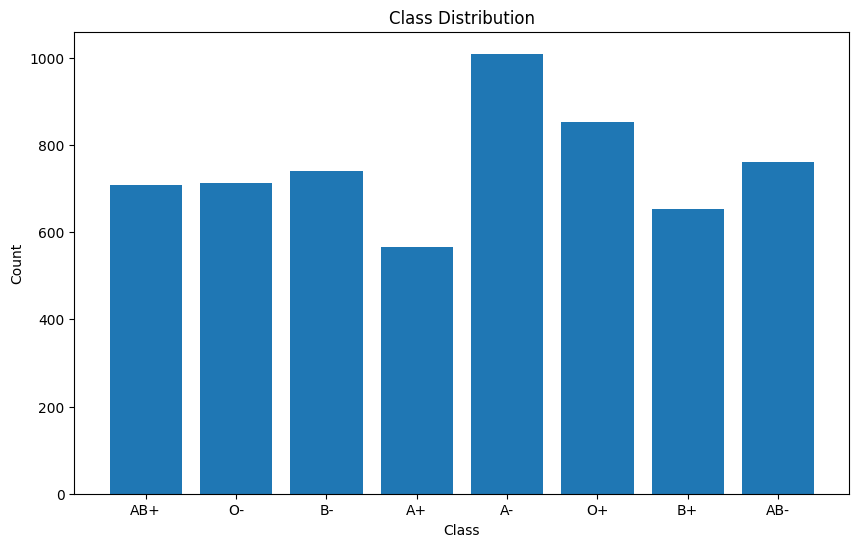

In [22]:
 plot_class_distribution(class_names,class_counts)

In [23]:
max_count= max(class_counts.values())

In [24]:
# FUNCTION TO OVER SAMPLE A CLASS SO THAT PREVENT FROM OVERFITTING AND ALSO IMPROVES EFFICIENCY
def oversample_class(class_id,count,max_count):
  #ensure the dataset is unbatched for filtering
  unbatched_dataset= dataset.unbatch()

  #filter the dataset for the specific class
  class_dataset= unbatched_dataset.filter(lambda img,lbl : tf.equal(lbl,class_id))

  #calculate the number of repetitions needed
  repeat_factor= max_count//count+(max_count% count>0)

  #repeat the dataset to match the desired count
  return class_dataset.repeat(repeat_factor).take(max_count)


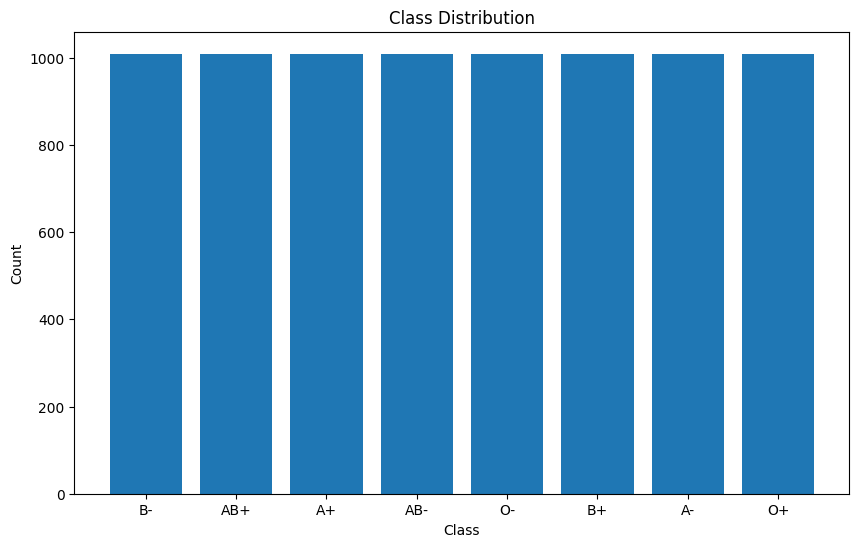

In [25]:
#step - 1 : Balance the dataset
balanced_datasets=[]
for class_id , count in class_counts.items():
  balanced_datasets.append(oversample_class(class_id,count,max_count))

#step - 2 : Combine balanced datasets
balanced_dataset = tf.data.Dataset.sample_from_datasets(balanced_datasets)

#step-3 : check balanced class distribution
balanced_class_counts =Counter([int(lbl.numpy()) for _, lbl in balanced_dataset])
plot_class_distribution(class_names,balanced_class_counts)

# step-4: batch the balanced dataset
balanced_dataset= balanced_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [26]:
#checking the dataset format
for sample in balanced_dataset.take(10):
  print(sample[0].shape)


(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)


In [27]:
balanced_dataset_unbatched = balanced_dataset.unbatch()
dataset_size= sum(1 for _ in balanced_dataset_unbatched)
print(f"Total number of samples in the balanced dataset: {dataset_size}")

Total number of samples in the balanced dataset: 8064


In [28]:
#unbatch the dataset to work at the sample level
balance_dataset_unbatched= balanced_dataset.unbatch()

#compute sizes based on dataset size and desired splits
train_size= int(0.7*dataset_size)
val_size= int(0.15*dataset_size)

#split the dataset into training, validation and test
train_dataset= balanced_dataset_unbatched.take(train_size)
val_test_dataset= balance_dataset_unbatched.skip(train_size)
val_dataset= val_test_dataset.take(val_size)
test_dataset= val_test_dataset.skip(val_size)

#Rebatch the datasets after splitting
train_dataset=train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset=val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset=test_dataset.batch(BATCH_SIZE, drop_remainder=True)

#check the number of batches in each dataset
train_batch_count= sum(1 for _ in train_dataset)
val_batch_count= sum(1 for _ in val_dataset)
test_batch_count= sum(1 for _ in test_dataset)

print(f"Number of batches in the training dataset: {train_batch_count}")
print(f"Number of batches in the validation dataset: {val_batch_count}")
print(f"Number of batches in the test dataset: {test_batch_count}")


Number of batches in the training dataset: 176
Number of batches in the validation dataset: 37
Number of batches in the test dataset: 37


In [29]:
def create_high_accuracy_model():
  model=tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32,(3,3),activation="relu", padding='same',input_shape=(64,64,3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.3),

      tf.keras.layers.Conv2D(64,(3,3),activation="relu", padding='same'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.4),

      tf.keras.layers.Conv2D(128,(3,3),activation="relu", padding='same'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.4),

       tf.keras.layers.Conv2D(256,(3,3),activation="relu", padding='same'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.4),

      tf.keras.layers.Conv2D(512,(3,3),activation="relu", padding='same'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.5),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(1024,activation="relu"),
      tf.keras.layers.Dropout(0.5),

      tf.keras.layers.Dense(len(class_names), activation='softmax')
  ])
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

# Create the model
high_acc_model = create_high_accuracy_model()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

#define reduceLRonPlateau callback to reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6

)

# define EarlyStopping callback to stop training when validation loss doesn't improve
early_stop= EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)


In [31]:
# train the model
history_high_acc= high_acc_model.fit(
	train_dataset,
	validation_data= val_dataset,
	epochs=50,
	callbacks=[reduce_lr,early_stop]
)

Epoch 1/50
    176/Unknown 94s 517ms/step - accuracy: 0.1300 - loss: 39.6320

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


176/176 ━━━━━━━━━━━━━━━━━━━━ 107s 588ms/step - accuracy: 0.1300 - loss: 39.4674 - val_accuracy: 0.1365 - val_loss: 2.0241 - learning_rate: 0.0010
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 104s 592ms/step - accuracy: 0.1555 - loss: 2.0796 - val_accuracy: 0.2048 - val_loss: 1.9939 - learning_rate: 0.0010
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 142s 807ms/step - accuracy: 0.3640 - loss: 1.6745 - val_accuracy: 0.3766 - val_loss: 1.7616 - learning_rate: 0.0010
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 105s 594ms/step - accuracy: 0.5121 - loss: 1.3137 - val_accuracy: 0.4564 - val_loss: 1.5241 - learning_rate: 0.0010
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 102s 580ms/step - accuracy: 0.5963 - loss: 1.1014 - val_accuracy: 0.5025 - val_loss: 1.4911 - learning_rate: 0.0010
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 102s 579ms/step - accuracy: 0.6346 - loss: 0.9829 - val_accuracy: 0.5938 - val_loss: 1.2331 - learning_rate: 0.0010
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 102s 579ms/step - accuracy: 0.6630

In [32]:
high_acc_eval= high_acc_model.evaluate(val_dataset)
print(f"High Accuracy Model - Loss: {high_acc_eval[0]}, Accuracy: {high_acc_eval[1]}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - accuracy: 0.9434 - loss: 0.3218
High Accuracy Model - Loss: 0.3315306305885315, Accuracy: 0.9013158082962036


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


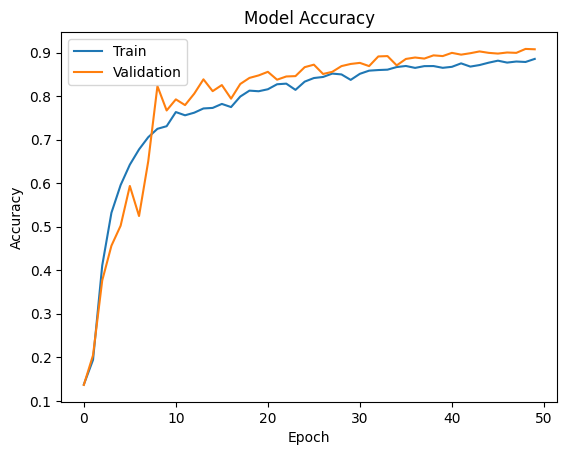

In [34]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy values
def plot_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train','Validation'], loc='upper left')
  plt.show()

plot_accuracy(history_high_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

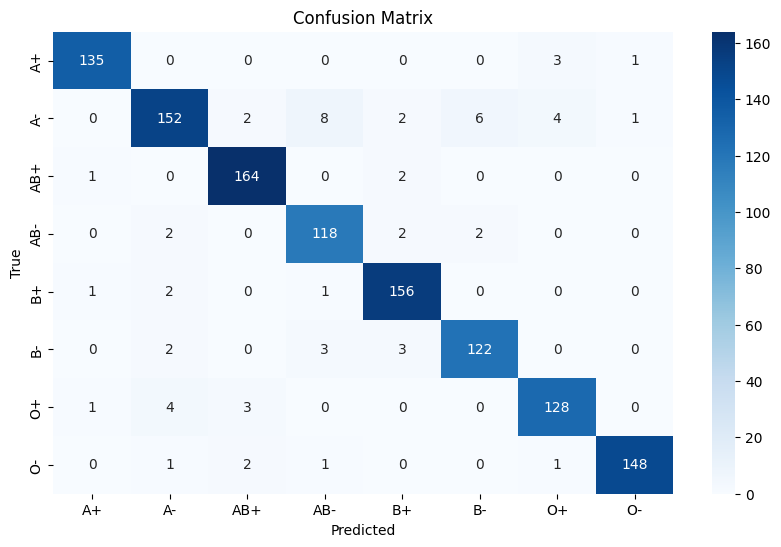

In [35]:
#Get predictions on the test dataset
y_true=[]
y_pred=[]

#iterate over the test dataset and collect the true and predicted labels
for images,labels in test_dataset:
  predictions= high_acc_model.predict(images)
  predicted_labels= np.argmax(predictions, axis=1) #conver one-hot encoded predictions to class labels
  y_true.extend(labels.numpy()) #convert tensor to numpy array and append
  y_pred.extend(predicted_labels) #Append the predicted labels

  #conver to numpy arrays
y_true= np.array(y_true)
y_pred = np.array(y_pred)

#classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

#Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

#plot confusion matrix
plt.figure(figsize=(10,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



In [39]:
high_acc_model.save("model.h5")
# The model will be saved as 'my_model.h5
print("Model saved as HDF5 format")

Model saved as HDF5 format


In [40]:
pip show pillow

Name: pillow
Version: 11.1.0
Summary: Python Imaging Library (Fork)
Home-page: https://python-pillow.github.io
Author: 
Author-email: "Jeffrey A. Clark" <aclark@aclark.net>
License: MIT-CMU
Location: /usr/local/lib/python3.11/dist-packages
Requires: 
Required-by: bokeh, diffusers, dopamine_rl, fastai, imageio, imgaug, matplotlib, scikit-image, sentence-transformers, torchvision, wordcloud
